# MI Classification with DiffE

In [ ]:
!pip install ema-pytorch
!pip install pytorch_metric_learning
!pip install mne #1.9.0
!pip install torchinfo

In [ ]:
import os
import sys

!git clone https://github.com/diffe2023/Diff-E.git
sys.path.append('/content/Diff-E')

# !git clone https://github.com/vlawhern/arl-eegmodels.git
# sys.path.append('/content/arl-eegmodels')

# !ls /content/arl-eegmodels


fatal: destination path 'Diff-E' already exists and is not an empty directory.


In [ ]:
import math
from einops import reduce
from functools import partial
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from ema_pytorch import EMA
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    top_k_accuracy_score,
)

# from EEGModels import EEGNet

In [ ]:
import mne
# import copy
import gdown
import scipy.io
# import string
# import re
# import json
# import gc
# import pandas as pd
# import pandas as pd
# import seaborn as sn

# from torchsummary import summary
# from torch.autograd import Variable
# from torch.utils.data import DataLoader, TensorDataset, random_split

# from sklearn.feature_selection import mutual_info_classif
# from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
!pip install --upgrade numpy==1.24.4

In [ ]:
# Uncomment this if you want to use Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p /content/drive/MyDrive/project/dataset/MI/cleaned_data/
!mkdir -p /content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session
!mkdir -p /content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session

#load and preprocess data


In [ ]:
raw = mne.io.read_raw_gdf('/content/drive/MyDrive/project/dataset/MI/raw_data/A01T.gdf', preload=False)
print("All unique event labels:")
print(np.unique(raw.annotations.description))


Extracting EDF parameters from /content/drive/MyDrive/project/dataset/MI/raw_data/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


All unique event labels:
['1023' '1072' '276' '277' '32766' '768' '769' '770' '771' '772']


In [ ]:
descs = raw.annotations.description
# Take the first 300 annotations and print the count of each type
from collections import Counter
print("[DEBUG] Distribution of annotation types in the first 300 entries:", Counter(descs[:300]))

# Display the contents of annotations 289–300 (to check for non-cue types)
print("[DEBUG] Annotations 289–300:", list(descs[288:300]))

[DEBUG] Distribution of annotation types in the first 300 entries: Counter({'768': 141, '772': 36, '771': 36, '770': 35, '769': 34, '1023': 9, '32766': 6, '276': 1, '277': 1, '1072': 1})
[DEBUG] Annotations 289–300: ['768', '769', '768', '772', '768', '771', '768', '771', '768', '771', '768', '771']


In [ ]:
raw2 = mne.io.read_raw_gdf('/content/drive/MyDrive/project/dataset/MI/raw_data/A01E.gdf', preload=False)
print("All unique event labels:")
print(np.unique(raw2.annotations.description))

Extracting EDF parameters from /content/drive/MyDrive/project/dataset/MI/raw_data/A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
All unique event labels:
['1023' '1072' '276' '277' '32766' '768' '783']


/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


In [ ]:
descs2 = raw2.annotations.description
# Take the first 300 annotations and print the count of each type
from collections import Counter
print("[DEBUG] Distribution of annotation types in the first 300 entries:", Counter(descs2[:300]))

# Display the contents of annotations 289–300 (to check for non-cue types)
print("[DEBUG] Annotations 289–300:", list(descs2[288:300]))

[DEBUG] Distribution of annotation types in the first 300 entries: Counter({'768': 143, '783': 142, '32766': 6, '1023': 6, '276': 1, '277': 1, '1072': 1})
[DEBUG] Annotations 289–300: ['783', '768', '783', '768', '783', '768', '783', '768', '783', '768', '783', '768']


In [ ]:
# raw_data_folder = '/content/drive/MyDrive/project/dataset/MI/raw_data/'
# cleaned_data_folder = '/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/'
# files = os.listdir(raw_data_folder)

# # Selecting files with suffix 'T.gdf'
# filtered_files = [file for file in files if file.endswith('T.gdf')]

# raw_list = []

# # Iterating through filtered files
# for file in filtered_files:
#     file_path = os.path.join(raw_data_folder, file)

#     # Reading raw data
#     raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)

#     # Droping EOG channels
#     raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

#     # High Pass Filtering 4-40 Hz
#     raw.filter(l_freq=4, h_freq=40, method='iir')

#     # Notch filter for Removal of Line Voltage
#     raw.notch_filter(freqs=50)

#     # Saving the modified raw data to a file with .fif suffix
#     new_file_path = os.path.join(cleaned_data_folder, file[:-4] + '.fif')
#     raw.save(new_file_path, overwrite=True)
#     # Appending data to the list
#     raw_list.append(raw)

# final_raw = mne.concatenate_raws(raw_list)
# new_file_path = os.path.join(cleaned_data_folder, 'First_Session_Subjects.fif')
# final_raw.save(new_file_path, overwrite=True)

FIRST SESSIONS

In [ ]:
# # Replace this with your actual shareable link
# shareable_link = 'https://drive.google.com/file/d/11Ke2Xta1kv2xu2Mybuu_X51zJYjQ-VFo/view?usp=drive_link'

# # Extract file ID from the shareable link
# file_id = shareable_link.split('/d/')[1].split('/view')[0]

# # Create the direct download link
# download_url = f'https://drive.google.com/uc?id={file_id}&export=download'

# # Specify the output file path
# output_file = 'true_labels.zip'

# # Download the file
# gdown.download(download_url, output_file, quiet=False)

In [ ]:
#%%capturey
# !unzip /content/true_labels.zip -d /content/drive/MyDrive/project/dataset/MI/second_session_labels/

In [ ]:
label_dir = "/content/drive/MyDrive/project/dataset/MI/second_session_labels"

for fname in sorted(os.listdir(label_dir)):
    if fname.endswith(".mat"):
        fpath = os.path.join(label_dir, fname)
        mat = scipy.io.loadmat(fpath)

        label_key = None
        for k in mat:
            if not k.startswith("__") and isinstance(mat[k], np.ndarray):
                print(f"{fname} - Possible key: {k} → shape: {mat[k].shape}")
                if "label" in k.lower():
                    label_key = k

        if label_key is None:
            print(f"{fname}: No valid label key found.\n")
            continue

        labels = mat[label_key].squeeze()
        print(f"📄 {fname}")
        print(f"→ key: {label_key}")
        print(f"→ shape: {labels.shape}, dtype: {labels.dtype}")
        print(f"→ unique labels: {np.unique(labels)}")
        print(f"→ first 10 labels: {labels[:10]}\n")


A01E.mat - Possible key: classlabel → shape: (288, 1)
📄 A01E.mat
→ key: classlabel
→ shape: (288,), dtype: uint8
→ unique labels: [1 2 3 4]
→ first 10 labels: [1 2 2 1 2 1 2 3 2 4]

A01T.mat - Possible key: classlabel → shape: (288, 1)
📄 A01T.mat
→ key: classlabel
→ shape: (288,), dtype: uint8
→ unique labels: [1 2 3 4]
→ first 10 labels: [4 3 2 1 1 2 3 4 2 3]

A02E.mat - Possible key: classlabel → shape: (288, 1)
📄 A02E.mat
→ key: classlabel
→ shape: (288,), dtype: uint8
→ unique labels: [1 2 3 4]
→ first 10 labels: [1 2 2 1 2 1 2 3 2 4]

A02T.mat - Possible key: classlabel → shape: (288, 1)
📄 A02T.mat
→ key: classlabel
→ shape: (288,), dtype: uint8
→ unique labels: [1 2 3 4]
→ first 10 labels: [1 2 2 1 2 1 2 3 2 4]

A03E.mat - Possible key: classlabel → shape: (288, 1)
📄 A03E.mat
→ key: classlabel
→ shape: (288,), dtype: uint8
→ unique labels: [1 2 3 4]
→ first 10 labels: [1 2 2 1 2 1 2 3 2 4]

A03T.mat - Possible key: classlabel → shape: (288, 1)
📄 A03T.mat
→ key: classlabel
→ shape

SECOND SESSION

In [ ]:
# raw_data_folder = '/content/drive/MyDrive/project/dataset/MI/raw_data/'
# cleaned_data_folder = '/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/'
# mat_folder = '/content/drive/MyDrive/project/dataset/MI/second_session_labels/'

# # Selecting files with suffix 'E.mat'
# mat_files = os.listdir(mat_folder)
# filtered_math_labels = [file for file in mat_files if file.endswith('E.mat')]

# # Selecting files with suffix 'E.gdf'
# files = os.listdir(raw_data_folder)
# filtered_files = [file for file in files if file.endswith('E.gdf')]

# raw_list = []
# second_session_labels = np.array([])
# # Iterating through filtered files
# for file in filtered_files:
#     file_path = os.path.join(raw_data_folder, file)

#     # Reading raw data
#     raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
#     # Droping EOG channels
#     raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

#     # High Pass Filtering 4-40 Hz
#     raw.filter(l_freq=4, h_freq=40, method='iir')

#     # Saving the modified raw data to a file with .fif suffix
#     new_file_path = os.path.join(cleaned_data_folder, file[:-4] + '.fif')
#     raw.save(new_file_path, overwrite=True)
#     # Appending data to t he list
#     raw_list.append(raw)

#     # Mat files for the labels
#     mat_file_name = file.replace('.gdf', '.mat')
#     mat_file_path = os.path.join(mat_folder, mat_file_name)
#     print(f"data:{file}, label:{mat_file_name}")

#     if os.path.exists(mat_file_path):
#         mat_data = scipy.io.loadmat(mat_file_path)
#         class_labels = mat_data.get('classlabel', [])

#         # Check if 'classlabel' key exists and is not empty
#         if class_labels.size > 0:
#              # Convert to a NumPy array and flatten
#             class_labels_array = np.array(class_labels, dtype=int).flatten()
#             # Concatenate with the existing test_labels array
#             second_session_labels = np.concatenate((second_session_labels, class_labels_array))
#         else:
#             print(f"Warning: 'classlabel' not found or empty in {mat_file_name}.")
#     else:
#         print(f"Warning: {mat_file_name} not found.")

# final_raw = mne.concatenate_raws(raw_list)
# new_file_path = os.path.join(cleaned_data_folder, 'Second_Session_Subjects.fif')
# final_raw.save(new_file_path, overwrite=True)

In [ ]:
# mne.sys_info()

In [ ]:
def check_mi_completeness(root_dir, subject_ids=list(range(1, 10))):
    sessions = ["first_session", "second_session"]
    mi_keys = ['769', '770', '771', '772']
    incomplete_subjects = []

    for sid in subject_ids:
        for sess in sessions:
            prefix = "T" if sess == "first_session" else "E"
            fname = f"A{sid:02d}{prefix}.fif"
            fpath = os.path.join(root_dir, sess, fname)

            if not os.path.exists(fpath):
                print(f"[ERROR] Missing file: {fpath}")
                continue

            try:
                raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)
                _, event_id = mne.events_from_annotations(raw, verbose=False)

                # Extract events and event_id from annotations
                events, event_id = mne.events_from_annotations(raw, verbose=False)
                from collections import Counter
                label_counts = Counter(events[:, 2])

                # Reverse the event_id dictionary to get {event_code: label}
                inverse_event_id = {v: k for k, v in event_id.items()}

                # Identify event codes that appear exactly 72 times (expected count for MI classes)
                mi_event_ids = [eid for eid, count in label_counts.items() if count == 72]
                motor_event_id = {inverse_event_id[eid]: eid for eid in mi_event_ids if eid in inverse_event_id}

                print(f"[DEBUG] Subject {sid} {sess} candidate MI labels: {list(motor_event_id.keys())}")

                if len(motor_event_id) < 4:
                    print(f"[✗] Subject {sid} {sess}: MI types missing → found {list(motor_event_id.keys())}")
                    incomplete_subjects.append((sid, sess))
                    continue


                # Filter events to include only MI-related ones
                events, _ = mne.events_from_annotations(raw, verbose=False)
                mi_events = np.array([e for e in events if e[2] in motor_event_id.values()])
                counts = {k: 0 for k in mi_keys}
                for e in mi_events:
                    for k, v in motor_event_id.items():
                        if e[2] == v:
                            counts[k] += 1

                if any(v != 72 for v in counts.values()):
                    print(f"[✗] Subject {sid} {sess}: Incomplete trials → {counts}")
                    incomplete_subjects.append((sid, sess))
                else:
                    print(f"[✓] Subject {sid} {sess}: All MI classes OK")

            except Exception as e:
                print(f"[ERROR] Subject {sid} {sess}: Failed to load – {e}")
                incomplete_subjects.append((sid, sess))

    return incomplete_subjects

root_dir = "/content/drive/MyDrive/project/dataset/MI/cleaned_data"
incomplete = check_mi_completeness(root_dir)

print("\n=== Summary: Incomplete Sessions ===")
for sid, sess in incomplete:
    print(f"Subject {sid} - {sess}")


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A01T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 1 first_session candidate MI labels: ['772', '771', '770', '769']
[✓] Subject 1 first_session: All MI classes OK


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A01E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 1 second_session candidate MI labels: []
[✗] Subject 1 second_session: MI types missing → found []


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A02T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 2 first_session candidate MI labels: ['769', '770', '771', '772']
[✓] Subject 2 first_session: All MI classes OK


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A02E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 2 second_session candidate MI labels: []
[✗] Subject 2 second_session: MI types missing → found []


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A03T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 3 first_session candidate MI labels: ['769', '770', '771', '772']
[✓] Subject 3 first_session: All MI classes OK


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A03E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 3 second_session candidate MI labels: []
[✗] Subject 3 second_session: MI types missing → found []


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A04T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 4 first_session candidate MI labels: ['772', '769', '770', '771']
[✓] Subject 4 first_session: All MI classes OK


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A04E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 4 second_session candidate MI labels: []
[✗] Subject 4 second_session: MI types missing → found []


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A05T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 5 first_session candidate MI labels: ['769', '770', '771', '772']
[✓] Subject 5 first_session: All MI classes OK


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A05E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 5 second_session candidate MI labels: []
[✗] Subject 5 second_session: MI types missing → found []


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A06T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 6 first_session candidate MI labels: ['772', '770', '769', '771']
[✓] Subject 6 first_session: All MI classes OK


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A06E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 6 second_session candidate MI labels: []
[✗] Subject 6 second_session: MI types missing → found []


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A07T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 7 first_session candidate MI labels: ['769', '770', '771', '772']
[✓] Subject 7 first_session: All MI classes OK


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A07E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 7 second_session candidate MI labels: []
[✗] Subject 7 second_session: MI types missing → found []


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A08T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 8 first_session candidate MI labels: ['769', '770', '771', '772']
[✓] Subject 8 first_session: All MI classes OK


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A08E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 8 second_session candidate MI labels: []
[✗] Subject 8 second_session: MI types missing → found []


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A09T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 9 first_session candidate MI labels: ['772', '770', '769', '771']
[✓] Subject 9 first_session: All MI classes OK


<ipython-input-18-6ec144fe559d>:17: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A09E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=False, verbose=False)


[DEBUG] Subject 9 second_session candidate MI labels: []
[✗] Subject 9 second_session: MI types missing → found []

=== Summary: Incomplete Sessions ===
Subject 1 - second_session
Subject 2 - second_session
Subject 3 - second_session
Subject 4 - second_session
Subject 5 - second_session
Subject 6 - second_session
Subject 7 - second_session
Subject 8 - second_session
Subject 9 - second_session


In [ ]:
def check_second_session_alignment(root_dir, label_dir, subject_id):
    prefix = "E"
    fif_path = os.path.join(root_dir, "second_session", f"A{subject_id:02d}{prefix}.fif")
    mat_path = os.path.join(label_dir, f"A{subject_id:02d}E.mat")

    print(f"Checking subject {subject_id}:")
    print(f"  FIF file: {fif_path}")
    print(f"  MAT file: {mat_path}")

    # Load fif annotations
    raw = mne.io.read_raw_fif(fif_path, preload=False, verbose=False)
    mask = raw.annotations.description == '783'
    assert mask.sum() == 288, f"Expected 288 '783' annotations, got {mask.sum()}"
    cue_annot = raw.annotations[mask]
    fif_onset_order = np.argsort(cue_annot.onset)  # sort by time

    # Load mat labels
    mat = scipy.io.loadmat(mat_path)
    label_key = [k for k in mat if "label" in k.lower() and not k.startswith("__")][0]
    mat_labels = mat[label_key].squeeze()
    assert mat_labels.shape[0] == 288, f"{mat_path} expected 288 labels, got {mat_labels.shape}"
    mat_labels_adj = mat_labels - 1  # Convert from 1–4 to 0–3

    # Optional: reorder labels by onset order if needed
    mat_labels_sorted = mat_labels_adj  # assume already aligned

    # Compare distribution
    mismatch_count = 0
    for i in range(288):
        fif_idx = fif_onset_order[i]
        fif_label = mat_labels_sorted[i]
        print(f"  Trial {i}: FIF idx {fif_idx}, Label {fif_label}")

    print(f"[OK] Subject {subject_id} alignment check completed.")

# check subjects 5 and 6 (assuming these are your unseen subjects)
root_dir = "/content/drive/MyDrive/project/dataset/MI/cleaned_data"
label_dir = "/content/drive/MyDrive/project/dataset/MI/second_session_labels/"

for sid in [5, 6]:
    check_second_session_alignment(root_dir, label_dir, sid)


Checking subject 5:
  FIF file: /content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A05E.fif
  MAT file: /content/drive/MyDrive/project/dataset/MI/second_session_labels/A05E.mat
  Trial 0: FIF idx 0, Label 0
  Trial 1: FIF idx 1, Label 1
  Trial 2: FIF idx 2, Label 1
  Trial 3: FIF idx 3, Label 0
  Trial 4: FIF idx 4, Label 1
  Trial 5: FIF idx 5, Label 0
  Trial 6: FIF idx 6, Label 1
  Trial 7: FIF idx 7, Label 2
  Trial 8: FIF idx 8, Label 1
  Trial 9: FIF idx 9, Label 3
  Trial 10: FIF idx 10, Label 0
  Trial 11: FIF idx 11, Label 2
  Trial 12: FIF idx 12, Label 1
  Trial 13: FIF idx 13, Label 0
  Trial 14: FIF idx 14, Label 3
  Trial 15: FIF idx 15, Label 3
  Trial 16: FIF idx 16, Label 3
  Trial 17: FIF idx 17, Label 3
  Trial 18: FIF idx 18, Label 3
  Trial 19: FIF idx 19, Label 0
  Trial 20: FIF idx 20, Label 2
  Trial 21: FIF idx 21, Label 1
  Trial 22: FIF idx 22, Label 0
  Trial 23: FIF idx 23, Label 0
  Trial 24: FIF idx 24, Label 2
  Trial 25: FIF idx 25, 

<ipython-input-34-004ba475f36b>:11: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A05E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_path, preload=False, verbose=False)
<ipython-input-34-004ba475f36b>:11: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A06E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_path, preload=False, verbose=False)


#split data

We retain the original SSVEP data preprocessing procedures, including:

    - Bandpass filtering using a Butterworth filter (4–40 Hz), applied with zero-phase (forward and reverse) IIR method.
    - Notch filtering at 50 Hz to remove power line noise.
    - Manual removal of EOG channels: ['EOG-left', 'EOG-central', 'EOG-right'].
    - Epoch segmentation: trial-wise slicing into 0–4 s windows based on event annotations.
    - Sampling rate standardized to 250 Hz (original dataset).
Unlike the original setup where models are trained separately for each subject, we train a single model jointly across all subjects by concatenating all subjects' data.

In [ ]:
# Define a function to perform z-score normalization on the data
def zscore_norm(data):
    # Calculate the mean and standard deviation for each channel in each batch
    mean = torch.mean(data, dim=(1, 2))
    std = torch.std(data, dim=(1, 2))

    # Subtract the mean from each channel in each batch and divide by the standard deviation
    norm_data = (data - mean[:, None, None]) / std[:, None, None]

    return norm_data


# Define a function to perform min-max normalization on the data
def minmax_norm(data):
    # Calculate the minimum and maximum values for each channel and sequence in the batch
    min_vals = torch.min(data, dim=-1)[0]
    max_vals = torch.max(data, dim=-1)[0]

    # Scale the data to the range [0, 1]
    norm_data = (data - min_vals.unsqueeze(-1)) / (
        max_vals.unsqueeze(-1) - min_vals.unsqueeze(-1)
    )

    return norm_data

In [ ]:
class EEGDataset(Dataset):
    """Characterizes an EEG dataset for PyTorch (used for t-SNE plotting)."""

    def __init__(self, X, Y, subject_ids=None, transform=None):
        self.X = X                            # (n_epochs, n_channels, n_times)
        self.Y = Y                            # (n_epochs,)
        self.subject_ids = (subject_ids
                            if subject_ids is not None
                            else torch.zeros(len(Y), dtype=torch.long))
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x   = self.X[index]
        y   = self.Y[index]
        sid = self.subject_ids[index]
        if self.transform:
            x = self.transform(x)
        return x.squeeze(), y, sid


def split_by_class_and_run(Y, seed=44, trials_per_run=12, n_classes=4, n_runs=6, train_count=8, val_count=2, test_count=2, num_sessions=2):
    random.seed(seed)
    train_idx, val_idx, test_idx = [], [], []
    for cls in range(n_classes):
        cls_indices = (Y == cls).nonzero(as_tuple=True)[0]
        expected_count = trials_per_run * n_runs * num_sessions
        assert len(cls_indices) == expected_count, \
            f"Class {cls} expected {expected_count}, got {len(cls_indices)}"

        for run in range(n_runs):
            run_trials = cls_indices[run * trials_per_run: (run + 1) * trials_per_run].tolist()
            random.shuffle(run_trials)
            train_idx.extend(run_trials[:train_count])
            val_idx.extend(run_trials[train_count:train_count + val_count])
            test_idx.extend(run_trials[train_count + val_count:train_count + val_count + test_count])
    return train_idx, val_idx, test_idx


def load_data_by_session(root_dir, subject_id, session_folders, label_dir=label_dir):
    """
    root_dir/
      first_session/
        A01T_cleaned.fif … A09T_cleaned.fif
      second_session/
        A01E_cleaned.fif … A09E_cleaned.fif

    session_folders: list of folder names, e.g. ["first_session"] or ["second_session"]
    """
    X_list, Y_list = [], []

    for folder in session_folders:
        prefix = "T" if folder == "first_session" else "E"
        fname = f"A{subject_id:02d}{prefix}.fif"
        fpath = os.path.join(root_dir, folder, fname)
        raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)

        if folder == "first_session":
            # MI cue as '769'~'772'，mapping as 0–3 labels
            events, event_id = mne.events_from_annotations(raw, verbose=False)
            motor_keys = ['769', '770', '771', '772']
            motor_event_id = {k: v for k, v in event_id.items() if k in motor_keys}
            if len(motor_event_id) < 4:
                raise ValueError(f"{fname} missing MI cues. Found: {event_id}")
            events = np.array([e for e in events if e[2] in motor_event_id.values()])
            label_map = {
                motor_event_id['769']: 0,
                motor_event_id['770']: 1,
                motor_event_id['771']: 2,
                motor_event_id['772']: 3,
            }
            labels = np.array([label_map[e[-1]] for e in events])

        elif folder == "second_session":
            assert label_dir is not None, "Must provide label_dir for second_session"
            mat_path = os.path.join(label_dir, f"A{subject_id:02d}E.mat")
            mat = scipy.io.loadmat(mat_path)
            label_key = [k for k in mat if "label" in k.lower() and not k.startswith("__")][0]
            labels = mat[label_key].squeeze()
            assert labels.shape[0] == 288, f"{mat_path} expected 288 labels, got {labels.shape}"
            labels = labels - 1  # Convert from 1–4 to 0–3

            # cue '783' as unknown MI tasks
            mask = raw.annotations.description == '783'
            assert mask.sum() == 288, f"Expected 288 '783' cue annotations, got {mask.sum()}"

            cue_annot = raw.annotations[mask]
            raw.set_annotations(cue_annot)
            events, _ = mne.events_from_annotations(raw, verbose=False)

        epochs = mne.Epochs(
            raw, events,
            tmin=0.0,
            tmax=4.0,
            baseline=None,
            preload=True,
            verbose=False,
            event_repeated="drop"
        )
        data = epochs.get_data()
        X_list.append(torch.from_numpy(data).float())
        Y_list.append(torch.from_numpy(labels).long())

    X = torch.cat(X_list, dim=0)
    Y = torch.cat(Y_list, dim=0)
    return X, Y

def load_split_dataset(root_dir, num_seen, seed=43):
    random.seed(seed)

    all_subjects   = list(range(1, 10))
    seen_subjects  = random.sample(all_subjects, num_seen)
    unseen_subjects = [sid for sid in all_subjects if sid not in seen_subjects]

    split_cfg = {
        "train_val_test1": [(sid, ["first_session", "second_session"]) for sid in seen_subjects],
        "test2":     [(sid, ["first_session", "second_session"]) for sid in unseen_subjects],
    }

    print(f"[Split] Seen (train/val/test1): {seen_subjects}")
    print(f"[Split] Unseen (test2):        {unseen_subjects}")

    loaders = {}
    subject_id_dict = {}

    # load train_val data first
    X_train_all, Y_train_all, train_subject_ids = [], [], []
    X_val_all, Y_val_all, val_subject_ids = [], [], []
    X_test1_all, Y_test1_all, test1_subject_ids = [], [], []

    for sid in seen_subjects:
        for session in ["first_session", "second_session"]:
            X, Y = load_data_by_session(root_dir, sid, [session])
            train_idx, val_idx, test_idx = split_by_class_and_run(
                Y, seed=seed, num_sessions=1
            )

            X_train_all.append(X[train_idx])
            Y_train_all.append(Y[train_idx])
            train_subject_ids.extend([sid] * len(train_idx))

            X_val_all.append(X[val_idx])
            Y_val_all.append(Y[val_idx])
            val_subject_ids.extend([sid] * len(val_idx))

            X_test1_all.append(X[test_idx])
            Y_test1_all.append(Y[test_idx])
            test1_subject_ids.extend([sid] * len(test_idx))

    loaders["train"] = DataLoader(
        EEGDataset(torch.cat(X_train_all), torch.cat(Y_train_all),
                   subject_ids=torch.tensor(train_subject_ids, dtype=torch.long)),
        batch_size=32, shuffle=True)
    subject_id_dict["train"] = torch.tensor(train_subject_ids, dtype=torch.long)

    loaders["val"] = DataLoader(
        EEGDataset(torch.cat(X_val_all), torch.cat(Y_val_all),
                   subject_ids=torch.tensor(val_subject_ids, dtype=torch.long)),
        batch_size=32, shuffle=False)
    subject_id_dict["val"] = torch.tensor(val_subject_ids, dtype=torch.long)

    loaders["test1"] = DataLoader(
        EEGDataset(torch.cat(X_test1_all), torch.cat(Y_test1_all),
                   subject_ids=torch.tensor(test1_subject_ids, dtype=torch.long)),
        batch_size=32, shuffle=False)
    subject_id_dict["test1"] = torch.tensor(test1_subject_ids, dtype=torch.long)

    # Process unseen subjects: use all trials
    X_all, Y_all, subject_ids = [], [], []
    for sid in unseen_subjects:
        X, Y = load_data_by_session(root_dir, sid, ["first_session", "second_session"])
        X_all.append(X)
        Y_all.append(Y)
        subject_ids.extend([sid] * len(Y))

    loaders["test2"] = DataLoader(
        EEGDataset(torch.cat(X_all), torch.cat(Y_all),
                   subject_ids=torch.tensor(subject_ids, dtype=torch.long)),
        batch_size=32, shuffle=False)
    subject_id_dict["test2"] = torch.tensor(subject_ids, dtype=torch.long)

    for split in ["train", "val", "test1", "test2"]:
        subj_tensor = subject_id_dict[split]
        total_trials = subj_tensor.shape[0]
        unique_subjects = subj_tensor.unique()
        print(f"\n[Check] Split: {split}")
        print(f"  Total trials: {total_trials}")
        print(f"  Unique subjects: {list(unique_subjects.numpy())}")
        for sid in unique_subjects:
            sid_count = (subj_tensor == sid).sum().item()
            print(f"    Subject {sid.item()}: {sid_count} trials")

    return loaders

In [ ]:
seed = 44
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  44


In [ ]:
subject_chars_dir='/content/drive/MyDrive/project/dataset/MI/cleaned_data' # Where to store all character data
subject_ids = list(range(1, 10)) #35 samples + 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
batch_size2 = 260
seed = 44 #same as the training
shuffle = True

# load all subjects' data
loaders = load_split_dataset(subject_chars_dir, num_seen=7, seed=seed)
train_loader = loaders["train"]
val_loader = loaders["val"]
test1_loader = loaders["test1"]
test2_loader = loaders["test2"]
train_iter = iter(train_loader)


[Split] Seen (train/val/test1): [7, 2, 8, 4, 9, 3, 1]
[Split] Unseen (test2):        [5, 6]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A07T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)
<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A07E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)
<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/fir


[Check] Split: train
  Total trials: 2688
  Unique subjects: [1, 2, 3, 4, 7, 8, 9]
    Subject 1: 384 trials
    Subject 2: 384 trials
    Subject 3: 384 trials
    Subject 4: 384 trials
    Subject 7: 384 trials
    Subject 8: 384 trials
    Subject 9: 384 trials

[Check] Split: val
  Total trials: 672
  Unique subjects: [1, 2, 3, 4, 7, 8, 9]
    Subject 1: 96 trials
    Subject 2: 96 trials
    Subject 3: 96 trials
    Subject 4: 96 trials
    Subject 7: 96 trials
    Subject 8: 96 trials
    Subject 9: 96 trials

[Check] Split: test1
  Total trials: 672
  Unique subjects: [1, 2, 3, 4, 7, 8, 9]
    Subject 1: 96 trials
    Subject 2: 96 trials
    Subject 3: 96 trials
    Subject 4: 96 trials
    Subject 7: 96 trials
    Subject 8: 96 trials
    Subject 9: 96 trials

[Check] Split: test2
  Total trials: 1152
  Unique subjects: [5, 6]
    Subject 5: 576 trials
    Subject 6: 576 trials


In [ ]:
with torch.no_grad():
    x, y, sid = next(train_iter)
    unique_sids = torch.unique(sid)
    print("Unique subject IDs in this batch:", unique_sids.tolist())
    print("Count:", len(unique_sids))


Unique subject IDs in this batch: [1, 2, 3, 4, 7, 8, 9]
Count: 7


In [ ]:
print(len(train_loader.dataset), len(val_loader.dataset), len(test1_loader.dataset), len(test2_loader.dataset))

for x, y,_ in train_loader:
    print("X shape:", x.shape)
    print("Y shape:", y.shape)
    break  # the first batch

2688 672 672 1152
X shape: torch.Size([32, 22, 1001])
Y shape: torch.Size([32])


In [ ]:
from collections import Counter

def check_split_label_distribution(loaders):
    splits = ["train", "val", "test1", "test2"]
    for split in splits:
        dataset = loaders[split].dataset
        labels = dataset.Y.numpy()
        label_count = Counter(labels)
        total = len(labels)
        print(f"[Check] Split: {split}")
        print(f"  Total trials: {total}")
        for cls in range(4):
            count = label_count.get(cls, 0)
            percentage = count / total * 100
            print(f"    Class {cls}: {count} ({percentage:.2f}%)")
        print("")

check_split_label_distribution(loaders)


[Check] Split: train
  Total trials: 2688
    Class 0: 672 (25.00%)
    Class 1: 672 (25.00%)
    Class 2: 672 (25.00%)
    Class 3: 672 (25.00%)

[Check] Split: val
  Total trials: 672
    Class 0: 168 (25.00%)
    Class 1: 168 (25.00%)
    Class 2: 168 (25.00%)
    Class 3: 168 (25.00%)

[Check] Split: test1
  Total trials: 672
    Class 0: 168 (25.00%)
    Class 1: 168 (25.00%)
    Class 2: 168 (25.00%)
    Class 3: 168 (25.00%)

[Check] Split: test2
  Total trials: 1152
    Class 0: 288 (25.00%)
    Class 1: 288 (25.00%)
    Class 2: 288 (25.00%)
    Class 3: 288 (25.00%)



#model

Since the original cloned GitHub implementation (https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py) used Keras, it couldn't be directly moved to CUDA using .to(device), so we reimplemented it in PyTorch.
The __init__ part of EEGNet is kept the same as in the original code, except that the final softmax layer used for classification has been replaced with a fully connected (fc) layer to ensure compatibility with the encoder interface.
However, the forward method has been adjusted to align the output format with the downstream model requirements.


The overall model follows the original GitHub implementation, with a few necessary adjustments to align tensor time dimensions. Specifically, we aligned the temporal dimensions between up2 + temb and down1, up3 and x, and x_hat and x. These changes are clearly marked with comments in the code.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, nb_classes, Chans=64, Samples=128, dropoutRate=0.5,
                 kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):
        super(EEGNet, self).__init__()
        if dropoutType == 'Dropout':
            DropoutClass = nn.Dropout
        elif dropoutType == 'SpatialDropout2D':
            DropoutClass = lambda p: nn.Dropout2d(p)
        else:
            raise ValueError("dropoutType must be 'Dropout' or 'SpatialDropout2D'")

        # Block 1
        self.conv1 = nn.Conv2d(1, F1, kernel_size=(1, kernLength), padding='same', bias=False)
        self.bn1 = nn.BatchNorm2d(F1)

        self.depthwiseConv = nn.Conv2d(
            F1, F1 * D, kernel_size=(Chans, 1), groups=F1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.avgpool1 = nn.AvgPool2d(kernel_size=(1, 4))
        self.drop1 = DropoutClass(dropoutRate)

        # Block 2
        self.separable_depthwise = nn.Conv2d(
            F1 * D, F1 * D, kernel_size=(1, 16), groups=F1 * D, padding='same', bias=False
        )
        self.separable_pointwise = nn.Conv2d(
            F1 * D, F2, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(F2)
        self.activation2 = nn.ELU()
        self.avgpool2 = nn.AvgPool2d(kernel_size=(1, 8))
        self.drop2 = DropoutClass(dropoutRate)

        # Final dense layer
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(F2 * ((Samples // 4) // 8), nb_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):  # x: (N, 1, Chans, Samples)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.depthwiseConv(x)
        x = self.bn2(x)
        x = self.activation1(x)
        x = self.avgpool1(x)
        x = self.drop1(x)

        x = self.separable_depthwise(x)
        x = self.separable_pointwise(x)
        x = self.bn3(x)
        x = self.activation2(x)
        x = self.avgpool2(x)
        x = self.drop2(x)

        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x


In [ ]:
from torchinfo import summary
# Creating an EEGNet model
#eegnet_model = EEGNet(nb_classes=40, Chans=64, Samples=250, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')
model = EEGNet(nb_classes=4, Chans=22, Samples=1001,
                      dropoutRate=0.2, kernLength=64,
                      F1=16, D=2, F2=32, dropoutType='Dropout').to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

summary(model, input_size=(32,1, 22, 1001))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


Layer (type:depth-idx)                   Output Shape              Param #
EEGNet                                   [32, 4]                   --
├─Conv2d: 1-1                            [32, 16, 22, 1001]        1,024
├─BatchNorm2d: 1-2                       [32, 16, 22, 1001]        32
├─Conv2d: 1-3                            [32, 32, 1, 1001]         704
├─BatchNorm2d: 1-4                       [32, 32, 1, 1001]         64
├─ELU: 1-5                               [32, 32, 1, 1001]         --
├─AvgPool2d: 1-6                         [32, 32, 1, 250]          --
├─Dropout: 1-7                           [32, 32, 1, 250]          --
├─Conv2d: 1-8                            [32, 32, 1, 250]          512
├─Conv2d: 1-9                            [32, 32, 1, 250]          1,024
├─BatchNorm2d: 1-10                      [32, 32, 1, 250]          64
├─ELU: 1-11                              [32, 32, 1, 250]          --
├─AvgPool2d: 1-12                        [32, 32, 1, 31]           --
├─Dropo

#train

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 500

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for x, y, _ in train_loader:
        x = x.unsqueeze(1).to(device)  # [B, 64, 1000] → [B, 1, 64, 1000]
        y = y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += y.size(0)
        train_correct += (predicted == y).sum().item()

    train_acc = train_correct / train_total
    train_loss /= train_total

    # ---------- validate ----------
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for x, y, _ in val_loader:
            x = x.unsqueeze(1).to(device)  # add channel dimension
            y = y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            val_loss += loss.item() * x.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += y.size(0)
            val_correct += (predicted == y).sum().item()

    val_acc = val_correct / val_total
    val_loss /= val_total

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")


[Epoch 1] Train Loss: 1.3726 | Acc: 0.2924 || Val Loss: 1.3868 | Acc: 0.2500
[Epoch 2] Train Loss: 1.3235 | Acc: 0.3977 || Val Loss: 1.3642 | Acc: 0.3304
[Epoch 3] Train Loss: 1.2714 | Acc: 0.4516 || Val Loss: 1.3836 | Acc: 0.3006
[Epoch 4] Train Loss: 1.2201 | Acc: 0.5175 || Val Loss: 1.3752 | Acc: 0.3393
[Epoch 5] Train Loss: 1.1952 | Acc: 0.5454 || Val Loss: 1.4269 | Acc: 0.3006
[Epoch 6] Train Loss: 1.1701 | Acc: 0.5670 || Val Loss: 1.2692 | Acc: 0.4420
[Epoch 7] Train Loss: 1.1541 | Acc: 0.5871 || Val Loss: 1.4195 | Acc: 0.3155
[Epoch 8] Train Loss: 1.1226 | Acc: 0.6280 || Val Loss: 1.4155 | Acc: 0.3214
[Epoch 9] Train Loss: 1.1162 | Acc: 0.6321 || Val Loss: 1.2925 | Acc: 0.4360
[Epoch 10] Train Loss: 1.1018 | Acc: 0.6492 || Val Loss: 1.2221 | Acc: 0.4985
[Epoch 11] Train Loss: 1.0968 | Acc: 0.6514 || Val Loss: 1.3738 | Acc: 0.3542
[Epoch 12] Train Loss: 1.0823 | Acc: 0.6637 || Val Loss: 1.3125 | Acc: 0.4122
[Epoch 13] Train Loss: 1.0786 | Acc: 0.6689 || Val Loss: 1.1882 | Acc: 0.

In [ ]:
#best val acc: 0.6905

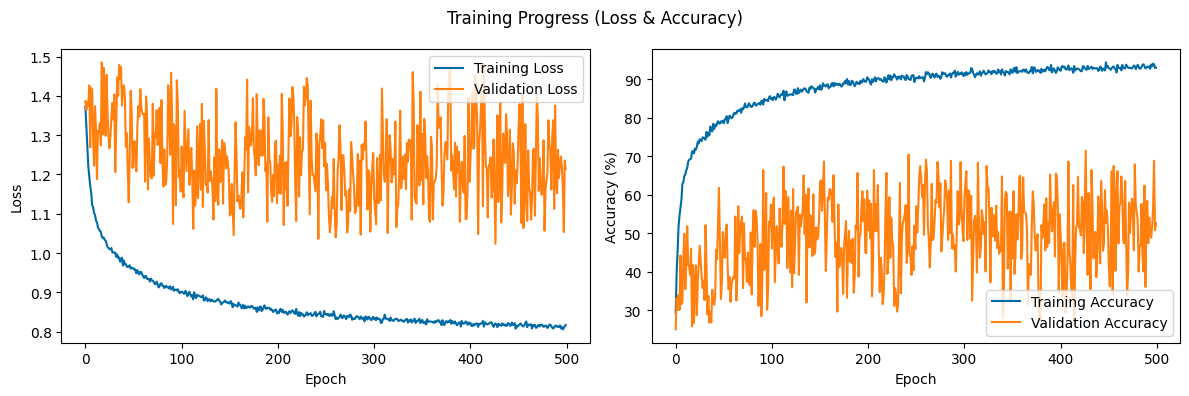

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.style.use('tableau-colorblind10')

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot([v * 100 for v in history["train_acc"]], label="Training Accuracy")
plt.plot([v * 100 for v in history["val_acc"]], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.suptitle("Training Progress (Loss & Accuracy)")
plt.tight_layout()
plt.show()

#evaluate on test datasets

In [ ]:
model.eval()
test1_loss, test1_correct, test1_total = 0, 0, 0

with torch.no_grad():
    for x, y, _ in test1_loader:
        x = x.unsqueeze(1).to(device)  # [B, 1, 64, 1000]
        y = y.to(device)

        outputs = model(x)
        loss = criterion(outputs, y)

        test1_loss += loss.item() * x.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test1_total += y.size(0)
        test1_correct += (predicted == y).sum().item()

test1_acc = test1_correct / test1_total
test1_loss /= test1_total
print(f"Test1 Loss: {test1_loss:.4f} | Acc: {test1_acc:.4f}")


Test1 Loss: 1.2009 | Acc: 0.5387


In [ ]:
model.eval()
test2_loss, test2_correct, test2_total = 0, 0, 0

with torch.no_grad():
    for x, y, _ in test2_loader:
        x = x.unsqueeze(1).to(device)
        y = y.to(device)

        outputs = model(x)
        loss = criterion(outputs, y)

        test2_loss += loss.item() * x.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test2_total += y.size(0)
        test2_correct += (predicted == y).sum().item()

test2_acc = test2_correct / test2_total
test2_loss /= test2_total
print(f"Test2 Loss: {test2_loss:.4f} | Acc: {test2_acc:.4f}")


Test2 Loss: 1.3545 | Acc: 0.3811


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn.functional as F

def run_baseline_per_subject_session(root_dir, label_dir, subject_ids, session_list, eegnet_model):
    results = {}
    for sid in subject_ids:
        for session in session_list:
            print(f"\n[Subject {sid} | Session {session}]")

            # --- load data ---
            X, Y = load_data_by_session(root_dir, sid, [session], label_dir=label_dir)
            X_np = X.numpy().reshape(X.shape[0], -1)  # flatten for sklearn
            Y_np = Y.numpy()

            # --- logistic regression ---
            clf = LogisticRegression(max_iter=1000)
            clf.fit(X_np, Y_np)
            acc = clf.score(X_np, Y_np)
            print(f"  [LogisticRegression] Accuracy: {acc:.4f}")

            # --- eegnet ---
            eegnet_model.eval()
            with torch.no_grad():
                outputs = eegnet_model(X.unsqueeze(1).to(next(eegnet_model.parameters()).device))
                pred = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                acc_nn = (pred.cpu() == Y).float().mean().item()
            print(f"  [EEGNet] Accuracy: {acc_nn:.4f}")

            results[(sid, session)] = {"logistic": acc, "eegnet": acc_nn}
    return results

# eegnet_model = EEGNet(nb_classes=4, Chans=22, Samples=1001,
#                       dropoutRate=0.2, kernLength=64,
#                       F1=16, D=2, F2=32, dropoutType='Dropout').to(device)


subject_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9]
session_list = ["first_session", "second_session"]
results = run_baseline_per_subject_session(root_dir, label_dir, subject_ids, session_list, model)



[Subject 1 | Session first_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A01T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.6181

[Subject 1 | Session second_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A01E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.6042

[Subject 2 | Session first_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A02T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.4549

[Subject 2 | Session second_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A02E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.4514

[Subject 3 | Session first_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A03T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.5833

[Subject 3 | Session second_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A03E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.6007

[Subject 4 | Session first_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A04T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.4722

[Subject 4 | Session second_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A04E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.4896

[Subject 5 | Session first_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A05T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.3160

[Subject 5 | Session second_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A05E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.3090

[Subject 6 | Session first_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A06T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.4514

[Subject 6 | Session second_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A06E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.4479

[Subject 7 | Session first_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A07T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.4792

[Subject 7 | Session second_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A07E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.4653

[Subject 8 | Session first_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A08T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.6528

[Subject 8 | Session second_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A08E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.5903

[Subject 9 | Session first_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/first_session/A09T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.8194

[Subject 9 | Session second_session]


<ipython-input-38-35fca0330f91>:58: RuntimeWarning: This filename (/content/drive/MyDrive/project/dataset/MI/cleaned_data/second_session/A09E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


  [LogisticRegression] Accuracy: 0.2500
  [EEGNet] Accuracy: 0.8333


#ML

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def run_simple_baseline(train_loader, val_loader, test1_loader, test2_loader):
    def collect_data(loader):
        X, y = [], []
        for x, y_batch, _ in loader:
            X.append(x.view(x.size(0), -1).numpy())
            y.append(y_batch.numpy())
        return np.vstack(X), np.hstack(y)

    X_train, y_train = collect_data(train_loader)
    X_val, y_val = collect_data(val_loader)
    X_test1, y_test1 = collect_data(test1_loader)
    X_test2, y_test2 = collect_data(test2_loader)

    # Logistic Regression
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    acc_val = accuracy_score(y_val, clf.predict(X_val))
    acc_test1 = accuracy_score(y_test1, clf.predict(X_test1))
    acc_test2 = accuracy_score(y_test2, clf.predict(X_test2))

    print(f"[LogisticRegression] Val Accuracy:   {acc_val:.4f}")
    print(f"[LogisticRegression] Test1 Accuracy: {acc_test1:.4f}")
    print(f"[LogisticRegression] Test2 Accuracy: {acc_test2:.4f}")

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)

    acc_rf_val = accuracy_score(y_val, rf.predict(X_val))
    acc_rf_test1 = accuracy_score(y_test1, rf.predict(X_test1))
    acc_rf_test2 = accuracy_score(y_test2, rf.predict(X_test2))

    print(f"[RandomForest] Val Accuracy:   {acc_rf_val:.4f}")
    print(f"[RandomForest] Test1 Accuracy: {acc_rf_test1:.4f}")
    print(f"[RandomForest] Test2 Accuracy: {acc_rf_test2:.4f}")


In [ ]:
run_simple_baseline(
    loaders["train"],
    loaders["val"],
    loaders["test1"],
    loaders["test2"]
)


[LogisticRegression] Val Accuracy:   0.2500
[LogisticRegression] Test1 Accuracy: 0.2500
[LogisticRegression] Test2 Accuracy: 0.2500
[RandomForest] Val Accuracy:   0.2887
[RandomForest] Test1 Accuracy: 0.3289
[RandomForest] Test2 Accuracy: 0.2708


In [ ]:
def run_per_subject_session_baseline(loaders, subject_ids):
    for sid in subject_ids:
        print(f"\n[Subject {sid}]")
        X_train, y_train, X_test, y_test = [], [], [], []

        # Train: subject sid, first_session
        for x, y, sid_batch in loaders["train"]:
            mask = sid_batch.numpy() == sid
            if np.any(mask):
                X_train.append(x[mask].view(-1, np.prod(x.shape[1:])).numpy())
                y_train.append(y[mask].numpy())

        # Test: subject sid, second_session (in val/test1)
        for x, y, sid_batch in loaders["val"]:
            mask = sid_batch.numpy() == sid
            if np.any(mask):
                X_test.append(x[mask].view(-1, np.prod(x.shape[1:])).numpy())
                y_test.append(y[mask].numpy())

        if not X_train or not X_test:
            print(f"  Skipped: no data for subject {sid}")
            continue

        X_train = np.vstack(X_train)
        y_train = np.hstack(y_train)
        X_test = np.vstack(X_test)
        y_test = np.hstack(y_test)

        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        print(f"  LogisticRegression Test Accuracy: {acc:.4f}")


In [ ]:
run_per_subject_session_baseline(loaders, subject_ids=[1, 2, 3, 4, 7, 8, 9])



[Subject 1]
  LogisticRegression Test Accuracy: 0.2500

[Subject 2]
  LogisticRegression Test Accuracy: 0.2500

[Subject 3]
  LogisticRegression Test Accuracy: 0.2500

[Subject 4]
  LogisticRegression Test Accuracy: 0.2500

[Subject 7]
  LogisticRegression Test Accuracy: 0.2500

[Subject 8]
  LogisticRegression Test Accuracy: 0.2500

[Subject 9]
  LogisticRegression Test Accuracy: 0.2500
